In [1]:
import sys
import os
copypath = ['../modules', 
            '../Train', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python27.zip', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/plat-linux2', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-tk', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-old', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-dynload', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg']
for p in reversed(copypath):
    sys.path.insert(0, p)
print sys.path
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['DEEPJET'] = '../../DeepJet'
#os.environ['LD_LIBRARY_PATH'] = '../modules:%s'%os.environ['LD_LIBRARY_PATH']
#os.environ['PATH'] = '../scripts:%s'%os.environ['PATH']
#os.environ['CONDA_PREFIX'] = '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu'
#os.environ['LD_PRELOAD'] = '%s/lib/libmkl_core.so:%s/lib/libmkl_sequential.so'%(os.environ['CONDA_PREFIX'],os.environ['CONDA_PREFIX'])
import keras
keras.backend.set_image_data_format('channels_last')

['../modules', '../Train', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python27.zip', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/plat-linux2', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-tk', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-old', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-dynload', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '', '/opt/conda/envs/python2/lib/python27.zip', '/opt/conda/envs/python2/lib/python2.7', '/opt/conda/envs/python2/lib/python2.7/plat-linux2', '/opt/conda/envs/python2/lib/python2.7/li

Using TensorFlow backend.


In [2]:
!nvidia-smi

Mon Sep 18 19:44:15 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   36C    P8     9W / 180W |      0MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   35C    P8    10W / 180W |      0MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
from keras.models import load_model, Model
from testing import testDescriptor
from argparse import ArgumentParser
from keras import backend as K
from Losses import * #needed!
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from root_numpy import array2root
import pandas as pd

In [4]:
def makeRoc(testd, model, outputDir):
    
    print 'in makeRoc()'
    #predict_test = np.zeros(testd.nsamples)
    #first = True
    #for sample in testd.samples[0:2]:
    #    print sample  
    #    td = testd.dataclass
    #    td.readIn(testd.getSamplePath(sample))
    #    if first:
    #        predict_test = model.predict(td.x)
    #    else:
    #        predict_test = np.append(predict_test,model.predict(td.x)) 
    #    first = False
    
    # let's use every jet
    NENT = 1
    features_val = [fval[::NENT] for fval in testd.getAllFeatures()]
    labels_val=testd.getAllLabels()[0][::NENT,:]
    #weights_val=testd.getAllWeights()[0][::NENT]
    spectators_val = testd.getAllSpectators()[0][::NENT,0,:]
    df = pd.DataFrame(spectators_val)
    df.columns = ['fj_pt',
                  'fj_eta',
                  'fj_sdmass',
                  'fj_n_sdsubjets',
                  'fj_doubleb',
                  'fj_tau21',
                  'fj_tau32',
                  'npv',
                  'npfcands',
                  'ntracks',
                  'nsv']

    print(df.iloc[:10])

        
    predict_test = model.predict(features_val)
    df['fj_isH'] = labels_val[:,1]
    df['fj_deepdoubleb'] = predict_test[:,1]
    df = df[(df.fj_sdmass > 40) & (df.fj_sdmass < 200) & (df.fj_pt > 300) &  (df.fj_pt < 2500)]

    print(df.iloc[:10])

    fpr, tpr, threshold = roc_curve(df['fj_isH'],df['fj_deepdoubleb'])
    dfpr, dtpr, threshold1 = roc_curve(df['fj_isH'],df['fj_doubleb'])

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx, array[idx]

    value = 0.01 # 1% mistag rate
    idx, val = find_nearest(fpr, value)
    deepdoublebcut = threshold[idx] # threshold for deep double-b corresponding to ~1% mistag rate
    print('deep double-b > %f coresponds to %f%% QCD mistag rate'%(deepdoublebcut,100*val))

    auc1 = auc(fpr, tpr)
    auc2 = auc(dfpr, dtpr)

    plt.figure()       
    plt.plot(tpr,fpr,label='deep double-b, auc = %.1f%%'%(auc1*100))
    plt.plot(dtpr,dfpr,label='BDT double-b, auc = %.1f%%'%(auc2*100))
    plt.semilogy()
    plt.xlabel("H(bb) efficiency")
    plt.ylabel("QCD mistag rate")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputDir+"test.pdf")
    
    plt.figure()
    bins = np.linspace(-1,1,70)
    plt.hist(df['fj_doubleb'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_doubleb'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel("BDT double-b")
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"doubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,1,70)
    plt.hist(df['fj_deepdoubleb'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_deepdoubleb'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel("deep double-b")
    #plt.ylim(0.00001,1)
    #plt.semilogy()
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"deepdoubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,2000,70)
    plt.hist(df['fj_pt'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_pt'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$p_{\mathrm{T}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"pt.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    plt.hist(df['fj_sdmass'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_sdmass'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    df_passdoubleb = df[df.fj_doubleb > 0.9]
    plt.hist(df_passdoubleb['fj_sdmass'], bins=bins, weights = 1-df_passdoubleb['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df_passdoubleb['fj_sdmass'], bins=bins, weights = df_passdoubleb['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd_passdoubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    df_passdeepdoubleb = df[df.fj_deepdoubleb > deepdoublebcut]
    plt.hist(df_passdeepdoubleb['fj_sdmass'], bins=bins, weights = 1-df_passdeepdoubleb['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df_passdeepdoubleb['fj_sdmass'], bins=bins, weights = df_passdeepdoubleb['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd_passdeepdoubleb.pdf")
    
    return df

In [5]:
!rm -r out_deep_sv

/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


in makeRoc()
ntuple_merged_0.z
ntuple_merged_10.z
ntuple_merged_11.z
ntuple_merged_12.z
ntuple_merged_13.z
ntuple_merged_14.z
ntuple_merged_15.z
ntuple_merged_16.z
ntuple_merged_17.z
ntuple_merged_18.z
ntuple_merged_19.z
ntuple_merged_1.z
ntuple_merged_20.z
ntuple_merged_21.z
ntuple_merged_22.z
ntuple_merged_23.z
ntuple_merged_24.z
ntuple_merged_25.z
ntuple_merged_26.z
ntuple_merged_27.z
ntuple_merged_28.z
ntuple_merged_29.z
ntuple_merged_2.z
ntuple_merged_30.z
ntuple_merged_31.z
ntuple_merged_32.z
ntuple_merged_33.z
ntuple_merged_34.z
ntuple_merged_35.z
ntuple_merged_36.z
ntuple_merged_37.z
ntuple_merged_3.z
ntuple_merged_4.z
ntuple_merged_5.z
ntuple_merged_6.z
ntuple_merged_7.z
ntuple_merged_8.z
ntuple_merged_9.z
ntuple_merged_0.z
ntuple_merged_10.z
ntuple_merged_11.z
ntuple_merged_12.z
ntuple_merged_13.z
ntuple_merged_14.z
ntuple_merged_15.z
ntuple_merged_16.z
ntuple_merged_17.z
ntuple_merged_18.z
ntuple_merged_19.z
ntuple_merged_1.z
ntuple_merged_20.z
ntuple_merged_21.z
ntuple_merg

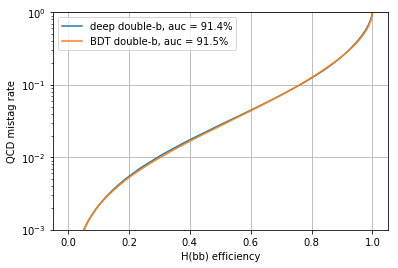

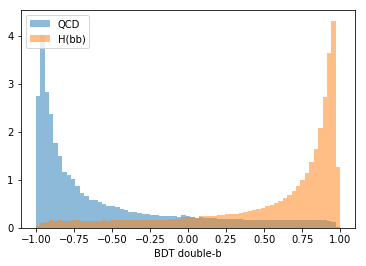

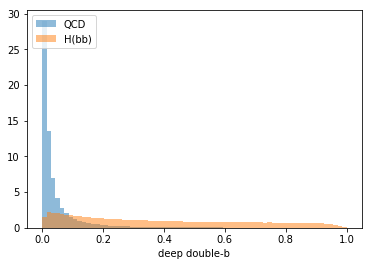

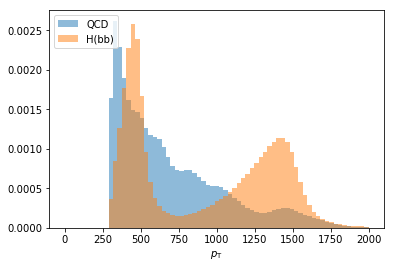

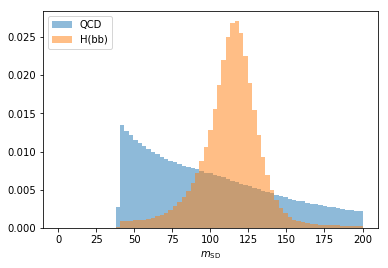

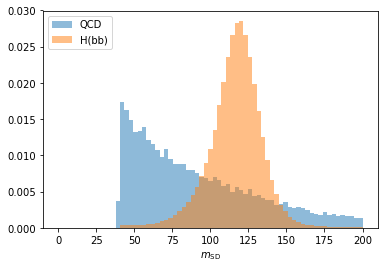

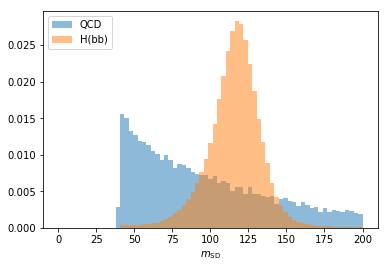

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

#inputModel = '/inputdata/BumbleB/jduarte/DeepJet/Train/train_Resnet_sv/KERAS_check_best_model.h5'
inputModel = 'train_deep_sv/KERAS_check_best_model.h5'
outputDir = 'out_deep_sv/'
# test data:
inputDataCollection = '/inputdata/BumbleB/convert_deepDoubleB_init_test_remove_msd40_200/dataCollection.dc'
# training data:
#inputDataCollection = '/inputdata/BumbleB/convert_deepDoubleB_init_train_val_remove_msd40_200/dataCollection.dc'

if os.path.isdir(outputDir):
    raise Exception('output directory must not exists yet')
else: 
    os.mkdir(outputDir)

model=load_model(inputModel, custom_objects=global_loss_list)
    
from DataCollection import DataCollection
    
testd=DataCollection()
testd.readFromFile(inputDataCollection)
    
df = makeRoc(testd, model, outputDir)

In [7]:
def _byteify(data, ignore_dicts = False):
    # if this is a unicode string, return its string representation
    if isinstance(data, unicode):
        return data.encode('utf-8')
    # if this is a list of values, return list of byteified values
    if isinstance(data, list):
        return [ _byteify(item, ignore_dicts=True) for item in data ]
    # if this is a dictionary, return dictionary of byteified keys and values
    # but only if we haven't already byteified it
    if isinstance(data, dict) and not ignore_dicts:
        return {
            _byteify(key, ignore_dicts=True): _byteify(value, ignore_dicts=True)
            for key, value in data.iteritems()
        }
    # if it's anything else, return it in its original form
    return data

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


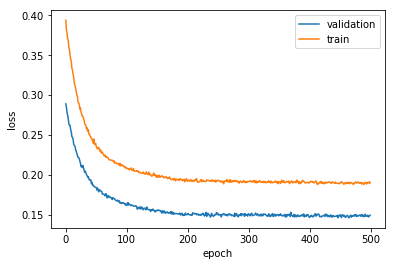

In [9]:
import json
inputLogs = 'train_deep_sv/full_info.log'
f = open(inputLogs)
myListOfDicts = json.load(f, object_hook=_byteify)
myDictOfLists = {}
for key, val in myListOfDicts[0].iteritems():
    myDictOfLists[key] = []
for i, myDict in enumerate(myListOfDicts):
    for key, val in myDict.iteritems():
        myDictOfLists[key].append(myDict[key])
val_loss = np.asarray(myDictOfLists['val_loss'])
loss = np.asarray(myDictOfLists['loss'])
plt.plot(val_loss, label='validation')
plt.plot(loss, label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig("out_deep_sv/loss.pdf")

In [10]:
model=load_model('train_deep_sv/KERAS_check_best_model.h5', custom_objects=global_loss_list)
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 27)         0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 5, 14)         0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 27)            0                                            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 70)            0                                            
___________________________________________________________________________________________